# Comparaison de performances d'attaques adverses (Mnist)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
from os.path import join


import numpy as np
import pandas as pd
import cv2
import pickle
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf



from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras import applications
from tensorflow.keras.layers import Dropout, Activation, Dense, GlobalMaxPooling2D,Conv2D,Flatten,MaxPooling2D,InputLayer
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7
from tensorflow.keras import datasets
from foolbox.attacks import LinfFastGradientAttack,LinfDeepFoolAttack
from foolbox.distances import LpDistance
from foolbox.models import TensorFlowModel
from foolbox import criteria
from sklearn.metrics import classification_report,plot_roc_curve

from art.attacks.evasion import SaliencyMapMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack
from art.utils import load_dataset #to play with cifar images

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)]
)

#### 1. Load Data

In [5]:
data=datasets.mnist.load_data(path='mnist.npz')
X_train,y_train=data[0][0],data[0][1]
X_test,y_test=data[1][0],data[1][1]
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [6]:
""" Train """
X_train_img = np.full((60000, 32, 32, 3), 0)
for i, s in enumerate(X_train):
    X_train_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
""" Test """
X_test_img = np.full((10000, 32, 32, 3), 0)
for i, s in enumerate(X_test):
    X_test_img[i] = cv2.cvtColor(np.pad(s,2), cv2.COLOR_GRAY2RGB) 
    
X_train=X_train_img
X_test= X_test_img

#### 2. Load models

Nous allons comparer les attaques sur efficientNet,VGG   


Afin de tester certaines attaques plus longues (comme JSMA) nous créons également un petit modèle 

In [7]:
effnet_base = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
effnet_base.trainable=True
x = GlobalMaxPooling2D(name='pool_1')(effnet_base.layers[-2].output)
x = Dropout(0.2, name="dropout_2")(x)
x = Dense(32)(x)
x = Dense(10,name='fc_2')(x)
o = Activation('softmax', name='act_2')(x)
model_effnet = Model(inputs=effnet_base.input, outputs=[o])

In [8]:
training_effnet=False

if training_effnet==True:
    model_effnet.compile(
        loss='categorical_crossentropy',
        optimizer='nadam',
        metrics=['accuracy']
        )
    history = model_effnet.fit(X_train, y_train,
                  epochs=5,
                  batch_size = 128,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=1)
    model_effnet.save('/media/hdd1/benchmark_adversarial_attacks/effnet_model.h5')
    
else:
    model_effnet=load_model('/media/hdd1/benchmark_adversarial_attacks/effnet_model.h5')
    

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 57s 1ms/sample - loss: 12.5468 - accuracy: 0.1068


KeyboardInterrupt: 

In [7]:
small_model = tf.keras.models.Sequential()
small_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32,32,3)))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Conv2D(64, (3, 3), activation='relu'))
small_model.add(MaxPooling2D(2, 2))
small_model.add(Flatten())
small_model.add(Dense(128, activation='relu'))
small_model.add(Dense(10, activation='softmax'))


small_model.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['accuracy']
    )

history = small_model.fit(X_train, y_train,
              epochs=5,
              batch_size = 128,
              validation_split=0.1,
              shuffle=True,
              verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 5s 98us/sample - loss: 1.3792 - accuracy: 0.9192 - val_loss: 0.0837 - val_accuracy: 0.9790
Epoch 2/5
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0713 - accuracy: 0.9788 - val_loss: 0.0764 - val_accuracy: 0.9792
Epoch 3/5
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0468 - accuracy: 0.9860 - val_loss: 0.0703 - val_accuracy: 0.9810
Epoch 4/5
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0351 - accuracy: 0.9891 - val_loss: 0.0677 - val_accuracy: 0.9842
Epoch 5/5
54000/54000 [==============================] - 4s 67us/sample - loss: 0.0302 - accuracy: 0.9906 - val_loss: 0.0706 - val_accuracy: 0.9850


### Some useful functions

Let's define the peformances metrics

In [2]:
def DOC (x_adv_list,x_list): #degree of change
    N=len(x_adv_list)
    sum=0
    for i in range (N):        
        sum+=100*np.linalg.norm(np.reshape(x_adv_list[i] - x_list[i], -1),ord=1)/np.linalg.norm(np.reshape(x_list[i], -1),ord=1)
    return(sum/N)

def succes_rate (success_list):
    success=len([i for i in success_list if i==True])
    total=len(success_list)
    return(success/total)

### Jacobian based saliency map

In [185]:
# classifier = TensorFlowV2Classifier(model=model_vgg, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
# attack =SaliencyMapMethod(classifier)




# x_test_adv = attack.generate(X_test[:5])



# predictions = classifier.predict(x_test_adv)
# accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
# print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

After 35 minutes working, JSMA had'nt even produced a single adversarial image for efficient net. Let's try on a smaller CNN

In [186]:
classifier = TensorFlowV2Classifier(model=small_model, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
attack =SaliencyMapMethod(classifier)




x_test_adv = attack.generate(X_test[:5])



predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


JSMA: 100%|██████████| 5/5 [08:52<00:00, 106.56s/it]

Accuracy on adversarial test examples: 0.0%



/home/timotheerio/adversarial_attakcs_benchmark/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


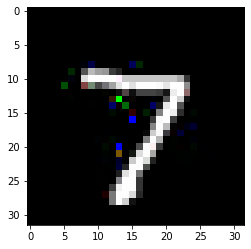

In [187]:
plt.imshow(x_test_adv[0]/255)

In [210]:
DOC(x_test_adv,X_test[:5])
#succes_rate([x_test_adv.all!=X_test[:5].all])

4.475278220098637

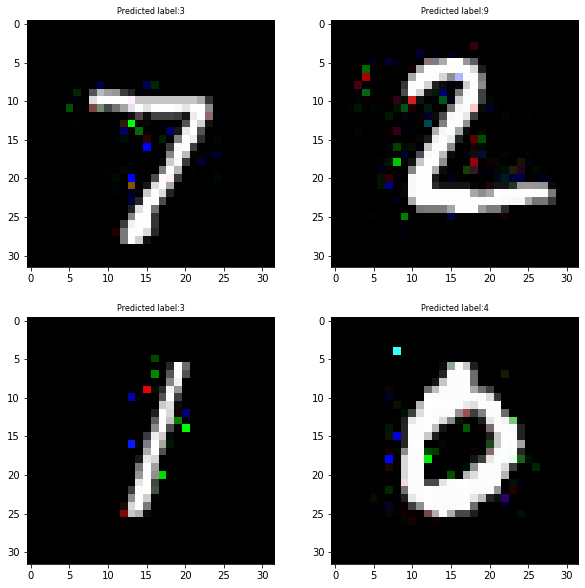

In [214]:
fig=plt.figure(figsize=(10,10))
columns = 2
rows = 2
for i in range(4):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(x_test_adv[i]/255)
    label=np.argmax(small_model.predict(np.expand_dims(x_test_adv[i],axis=0)))
    plt.title('Predicted label:'+str(label), fontsize=8)
plt.show()

###  Black box model: boundary attack



Boundary attack: 100%|██████████| 1/1 [00:00<00:00, 208.15it/s]

Adversarial image at step 0. L2 error 8000.655691570856 and class label 3.


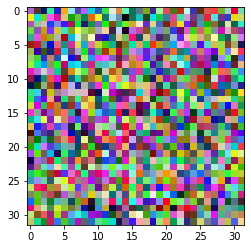



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.35s/it]

Adversarial image at step 200. L2 error 1196.6614377013343 and class label 3.


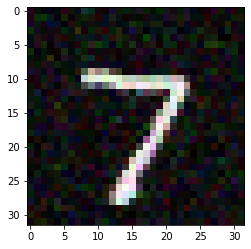



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.34s/it]

Adversarial image at step 400. L2 error 834.8885475477322 and class label 3.


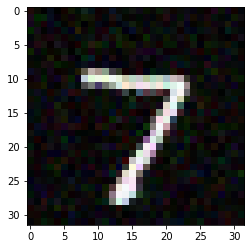



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:15<00:00, 15.87s/it]

Adversarial image at step 600. L2 error 704.1187573231449 and class label 3.


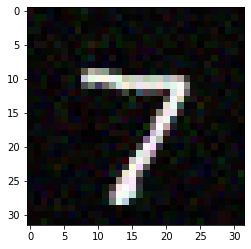



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.25s/it]

Adversarial image at step 800. L2 error 598.8714882232663 and class label 3.


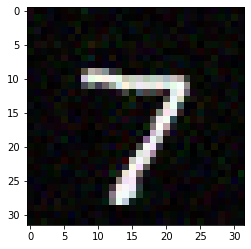



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.13s/it]

Adversarial image at step 1000. L2 error 546.4087628062615 and class label 3.


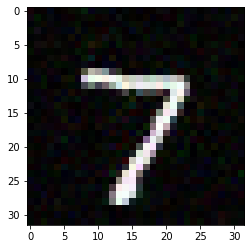



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.33s/it]

Adversarial image at step 1200. L2 error 503.7488980658936 and class label 3.


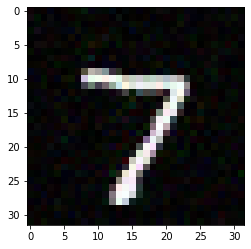



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.20s/it]

Adversarial image at step 1400. L2 error 469.9059175899147 and class label 3.


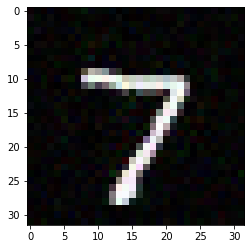



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:15<00:00, 15.76s/it]

Adversarial image at step 1600. L2 error 438.98086584553727 and class label 3.


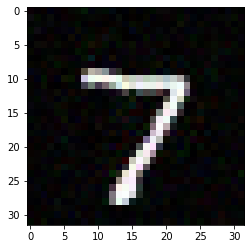



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:15<00:00, 15.83s/it]

Adversarial image at step 1800. L2 error 418.42918068224924 and class label 3.


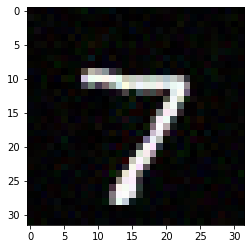



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.06s/it]

Adversarial image at step 2000. L2 error 399.36928669363385 and class label 3.


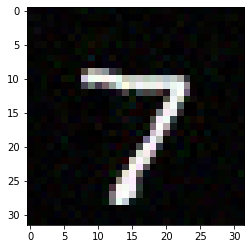



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:15<00:00, 15.81s/it]

Adversarial image at step 2200. L2 error 385.9112313971324 and class label 3.


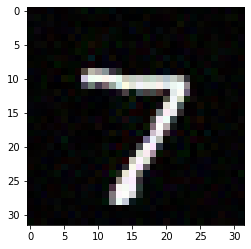



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:15<00:00, 16.00s/it]

Adversarial image at step 2400. L2 error 374.50065140218993 and class label 3.


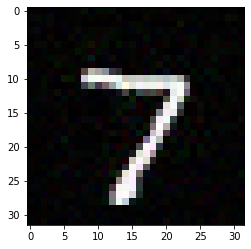



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.13s/it]

Adversarial image at step 2600. L2 error 363.8597332923228 and class label 3.


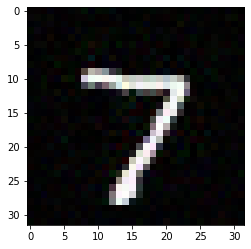



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack: 100%|██████████| 1/1 [00:16<00:00, 16.16s/it]

Adversarial image at step 2800. L2 error 355.09860432109144 and class label 3.


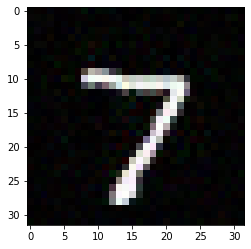



Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [257]:
classifier = TensorFlowV2Classifier(model=small_model, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step =200
x_adv = None
for i in range(20):
    x_adv = attack.generate(x=np.array([X_test[0]]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - X_test[0], [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break





Boundary attack: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Adversarial image at step 0. L2 error 8033.51698181182 and class label 4.


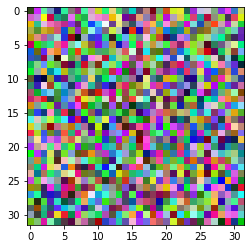

Boundary attack: 100%|██████████| 1/1 [00:10<00:00, 10.02s/it]


Adversarial image at step 1. L2 error 8025.566831764057 and class label 4.


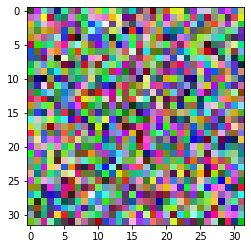

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.31s/it]


Adversarial image at step 2. L2 error 8013.5165402517605 and class label 4.


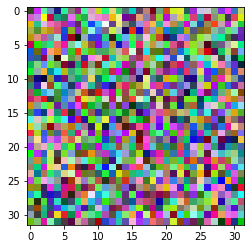

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.34s/it]


Adversarial image at step 3. L2 error 7995.614504093507 and class label 4.


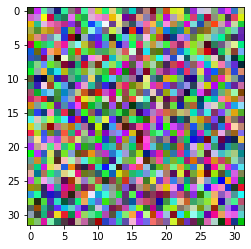

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.37s/it]


Adversarial image at step 4. L2 error 7968.249187449244 and class label 4.


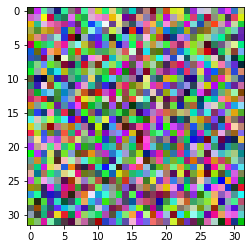

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.32s/it]


Adversarial image at step 5. L2 error 7927.78936748691 and class label 4.


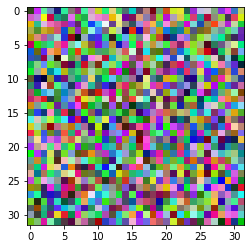

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.30s/it]


Adversarial image at step 6. L2 error 7867.986135886362 and class label 4.


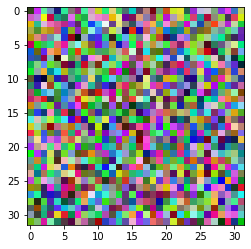

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.30s/it]


Adversarial image at step 7. L2 error 7780.43807278828 and class label 4.


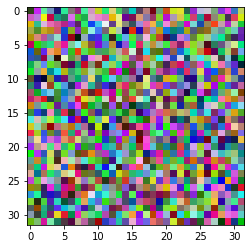

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]


Adversarial image at step 8. L2 error 7645.426326098867 and class label 4.


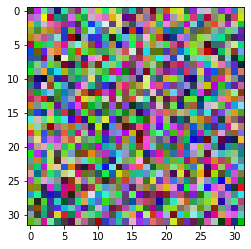

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.33s/it]


Adversarial image at step 9. L2 error 7457.539276245561 and class label 4.


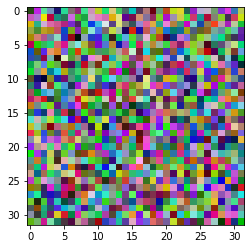

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


Adversarial image at step 10. L2 error 7174.546622768645 and class label 4.


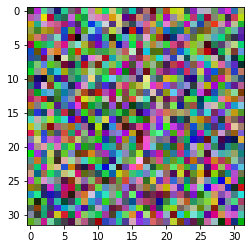

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.30s/it]


Adversarial image at step 11. L2 error 6762.61957689226 and class label 4.


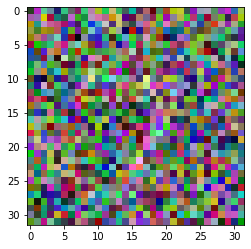

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


Adversarial image at step 12. L2 error 6174.436595955158 and class label 4.


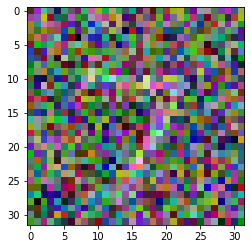

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.15s/it]


Adversarial image at step 13. L2 error 5374.555343634301 and class label 4.


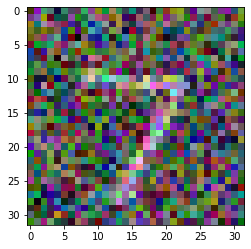

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]


Adversarial image at step 14. L2 error 4663.490199975434 and class label 4.


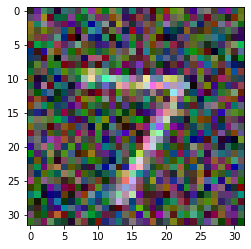

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Adversarial image at step 15. L2 error 4251.088356224296 and class label 4.


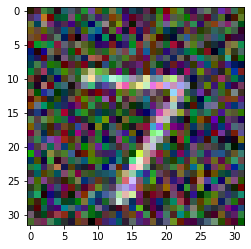

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Adversarial image at step 16. L2 error 3834.927654970556 and class label 4.


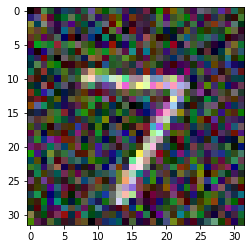

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Adversarial image at step 17. L2 error 3485.6017774327906 and class label 4.


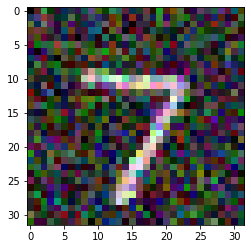

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


Adversarial image at step 18. L2 error 3021.9951580694656 and class label 4.


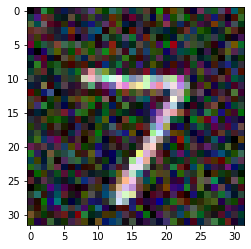

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


Adversarial image at step 19. L2 error 2826.0170916300663 and class label 4.


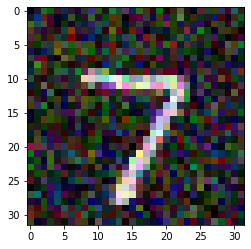

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


Adversarial image at step 20. L2 error 2575.0159671367505 and class label 4.


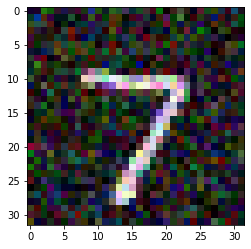

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


Adversarial image at step 21. L2 error 2334.147568915428 and class label 4.


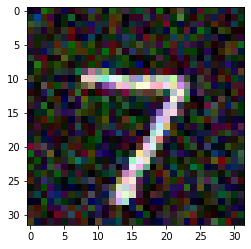

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.36s/it]


Adversarial image at step 22. L2 error 2124.332931672555 and class label 4.


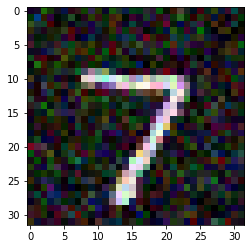

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Adversarial image at step 23. L2 error 1930.942422129897 and class label 4.


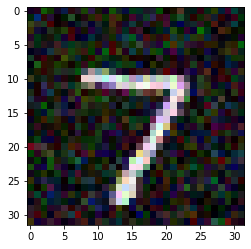

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 24. L2 error 1673.7448203185143 and class label 4.


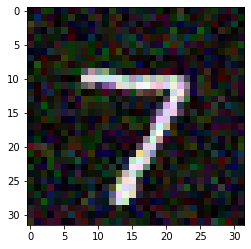

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


Adversarial image at step 25. L2 error 1526.0941567592913 and class label 4.


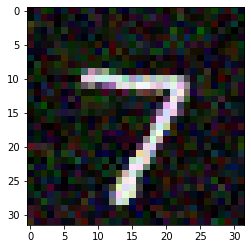

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Adversarial image at step 26. L2 error 1453.18692568099 and class label 4.


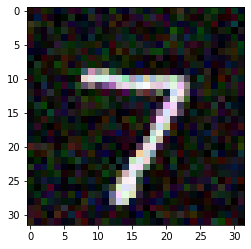

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


Adversarial image at step 27. L2 error 1393.7957412793046 and class label 4.


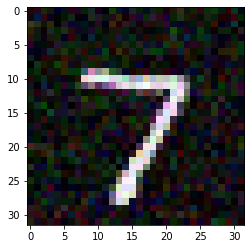

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.45s/it]


Adversarial image at step 28. L2 error 1370.2100882329637 and class label 4.


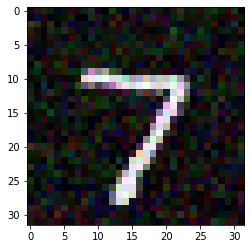

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.86s/it]


Adversarial image at step 29. L2 error 1344.810888576663 and class label 4.


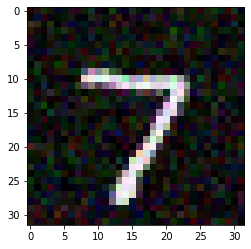

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


Adversarial image at step 30. L2 error 1308.3201057196875 and class label 4.


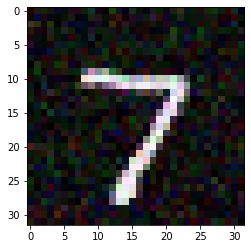

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Adversarial image at step 31. L2 error 1274.8792343452333 and class label 4.


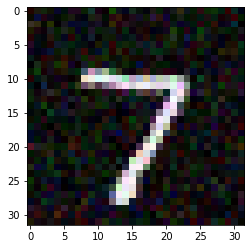

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


Adversarial image at step 32. L2 error 1260.5518902113574 and class label 4.


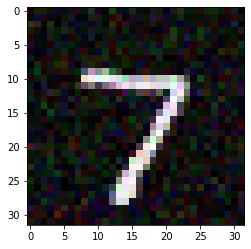

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


Adversarial image at step 33. L2 error 1237.9971664323534 and class label 4.


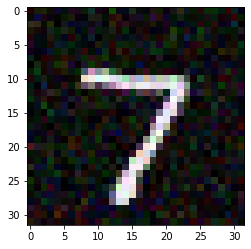

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.52s/it]


Adversarial image at step 34. L2 error 1217.8976700826786 and class label 4.


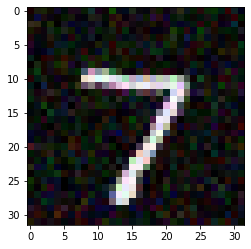

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]


Adversarial image at step 35. L2 error 1198.0732984296822 and class label 4.


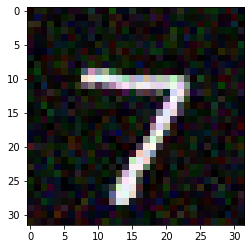

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


Adversarial image at step 36. L2 error 1178.0867989532699 and class label 4.


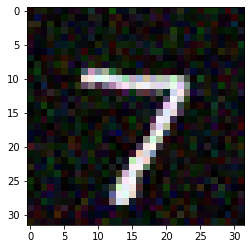

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.47s/it]


Adversarial image at step 37. L2 error 1157.504199216758 and class label 4.


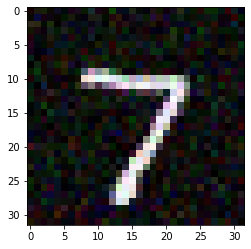

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


Adversarial image at step 38. L2 error 1138.4580372641146 and class label 4.


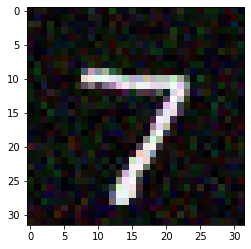

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Adversarial image at step 39. L2 error 1120.658669379359 and class label 4.


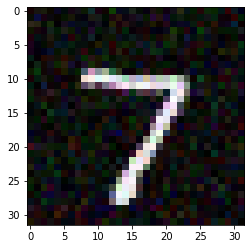

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.17s/it]


Adversarial image at step 40. L2 error 1108.1614670689776 and class label 4.


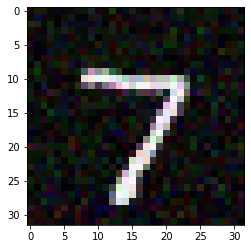

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


Adversarial image at step 41. L2 error 1098.5792272509161 and class label 4.


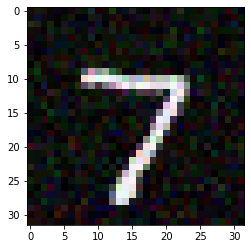

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Adversarial image at step 42. L2 error 1093.8657204162216 and class label 4.


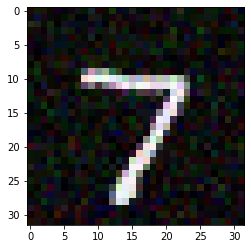

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


Adversarial image at step 43. L2 error 1089.5872315197184 and class label 4.


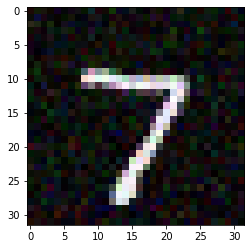

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Adversarial image at step 44. L2 error 1083.476301212214 and class label 4.


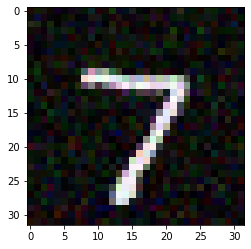

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 45. L2 error 1075.7976853932566 and class label 4.


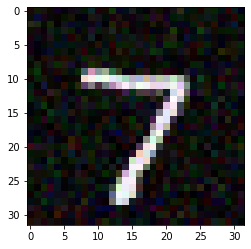

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]


Adversarial image at step 46. L2 error 1067.0889552764006 and class label 4.


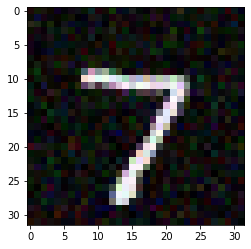

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.38s/it]


Adversarial image at step 47. L2 error 1059.7578941370143 and class label 4.


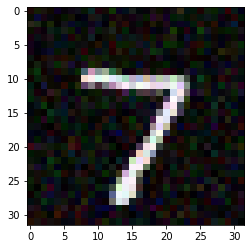

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


Adversarial image at step 48. L2 error 1050.8766738593304 and class label 4.


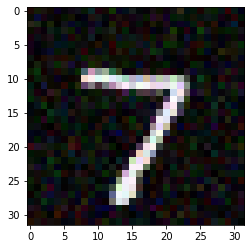

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


Adversarial image at step 49. L2 error 1039.7546572066835 and class label 4.


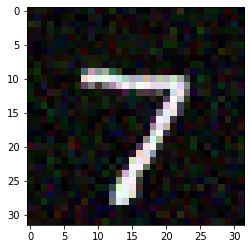

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


Adversarial image at step 50. L2 error 1027.533682961202 and class label 4.


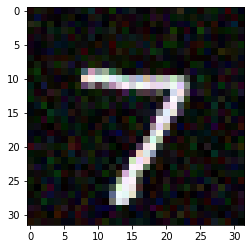

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


Adversarial image at step 51. L2 error 1015.1604860294807 and class label 4.


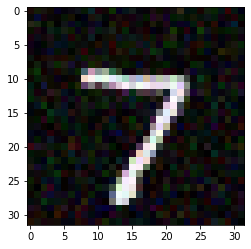

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


Adversarial image at step 52. L2 error 1002.6043032882951 and class label 4.


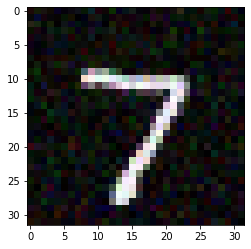

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Adversarial image at step 53. L2 error 994.1626972485954 and class label 4.


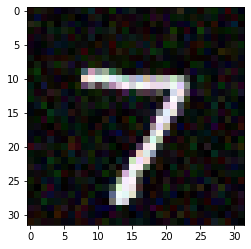

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


Adversarial image at step 54. L2 error 988.9203271837624 and class label 4.


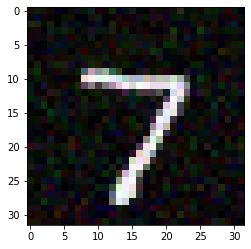

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


Adversarial image at step 55. L2 error 983.8631203229681 and class label 4.


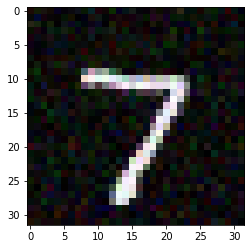

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Adversarial image at step 56. L2 error 978.8844870939884 and class label 4.


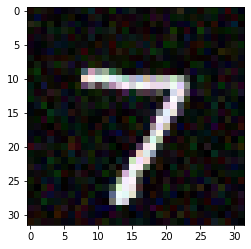

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


Adversarial image at step 57. L2 error 973.8656843651096 and class label 4.


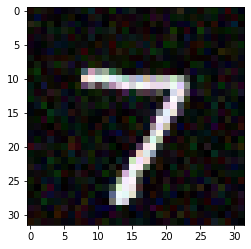

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]


Adversarial image at step 58. L2 error 968.9793501236246 and class label 4.


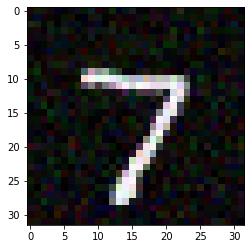

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


Adversarial image at step 59. L2 error 961.7439451328183 and class label 4.


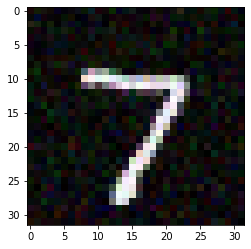

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


Adversarial image at step 60. L2 error 954.3564034961056 and class label 4.


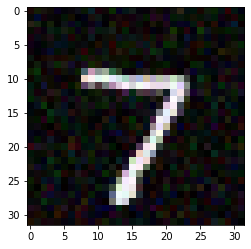

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.11s/it]


Adversarial image at step 61. L2 error 943.8792415411526 and class label 4.


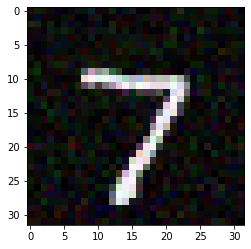

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Adversarial image at step 62. L2 error 939.7981435815549 and class label 4.


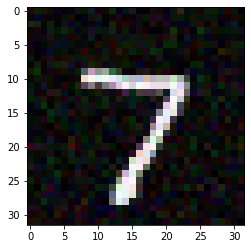

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


Adversarial image at step 63. L2 error 936.0313216482891 and class label 4.


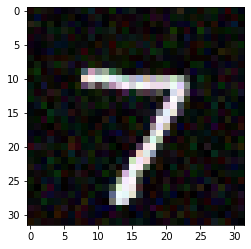

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


Adversarial image at step 64. L2 error 931.207070921519 and class label 4.


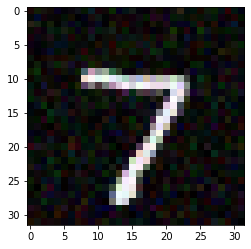

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 65. L2 error 926.7533862302683 and class label 4.


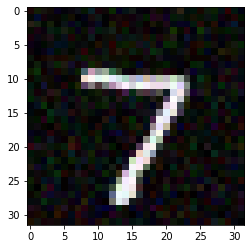

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


Adversarial image at step 66. L2 error 923.427276502676 and class label 4.


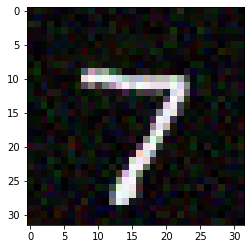

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


Adversarial image at step 67. L2 error 918.6141566475548 and class label 4.


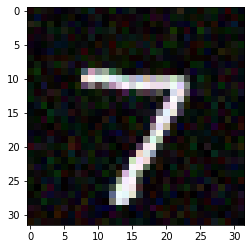

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Adversarial image at step 68. L2 error 913.434151414299 and class label 4.


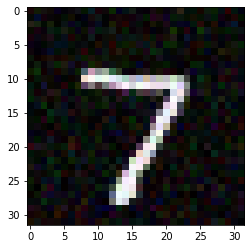

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


Adversarial image at step 69. L2 error 910.2147428382386 and class label 4.


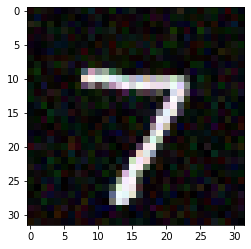

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.20s/it]


Adversarial image at step 70. L2 error 905.6148970510686 and class label 4.


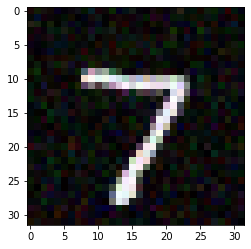

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.10s/it]


Adversarial image at step 71. L2 error 901.5016811977437 and class label 4.


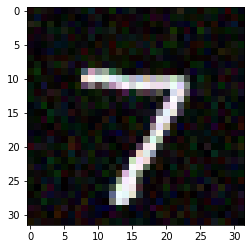

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


Adversarial image at step 72. L2 error 894.947512937272 and class label 4.


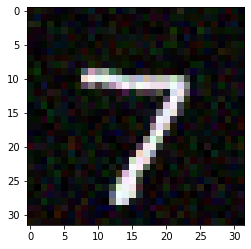

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


Adversarial image at step 73. L2 error 887.0376366554221 and class label 4.


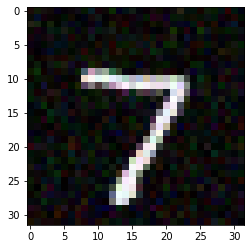

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


Adversarial image at step 74. L2 error 880.364207115358 and class label 4.


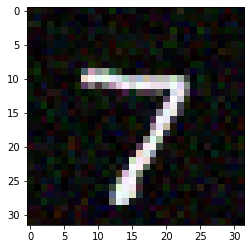

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


Adversarial image at step 75. L2 error 875.8015886707293 and class label 4.


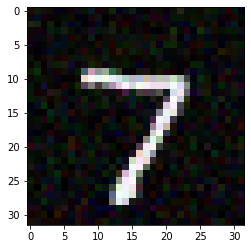

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]


Adversarial image at step 76. L2 error 872.3545018426813 and class label 4.


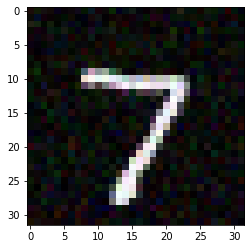

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


Adversarial image at step 77. L2 error 869.1746269681389 and class label 4.


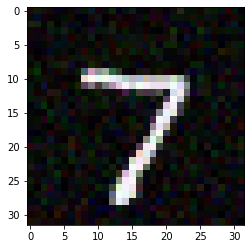

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


Adversarial image at step 78. L2 error 863.9523544609463 and class label 4.


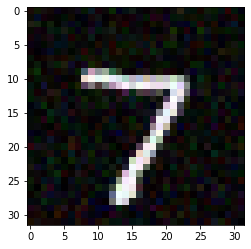

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.61s/it]


Adversarial image at step 79. L2 error 857.1190840659818 and class label 4.


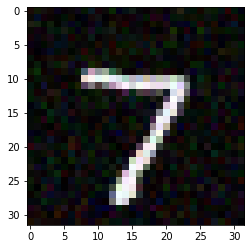

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


Adversarial image at step 80. L2 error 850.2681352449263 and class label 4.


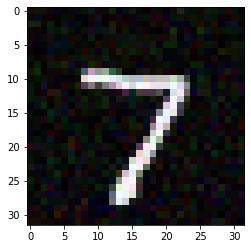

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Adversarial image at step 81. L2 error 843.6653060220211 and class label 4.


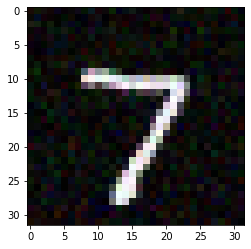

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


Adversarial image at step 82. L2 error 837.6438626403408 and class label 4.


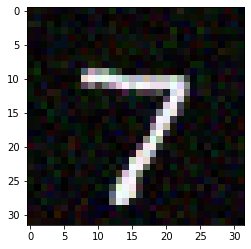

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.56s/it]


Adversarial image at step 83. L2 error 831.0991231883667 and class label 4.


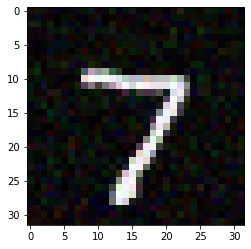

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Adversarial image at step 84. L2 error 827.324313963803 and class label 4.


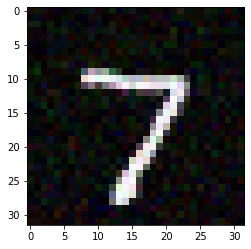

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]


Adversarial image at step 85. L2 error 825.4432656077591 and class label 4.


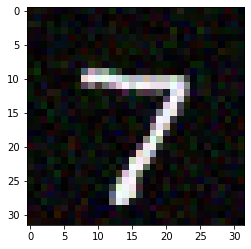

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 86. L2 error 822.6058814279634 and class label 4.


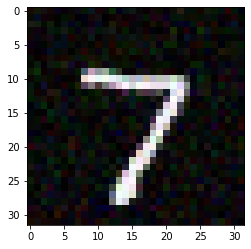

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


Adversarial image at step 87. L2 error 820.865135376764 and class label 4.


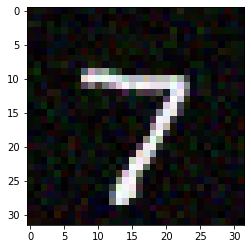

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.15s/it]


Adversarial image at step 88. L2 error 818.094283553451 and class label 4.


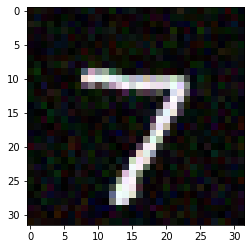

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.39s/it]


Adversarial image at step 89. L2 error 815.6387394985289 and class label 4.


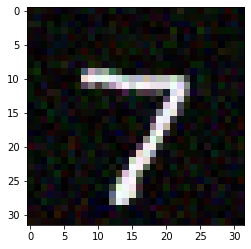

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Adversarial image at step 90. L2 error 812.34979186307 and class label 4.


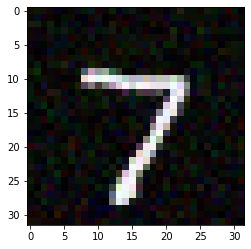

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


Adversarial image at step 91. L2 error 809.8973324255807 and class label 4.


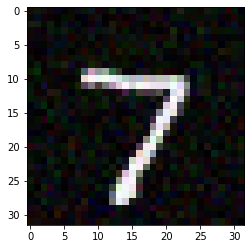

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


Adversarial image at step 92. L2 error 805.3019016803164 and class label 4.


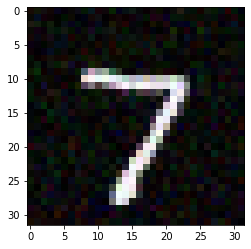

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


Adversarial image at step 93. L2 error 801.2037524307989 and class label 4.


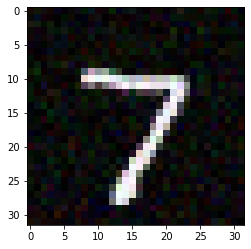

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]


Adversarial image at step 94. L2 error 797.2553677247057 and class label 4.


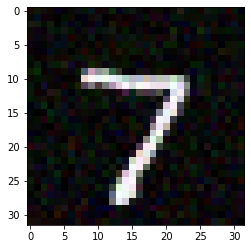

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


Adversarial image at step 95. L2 error 791.9496913077713 and class label 4.


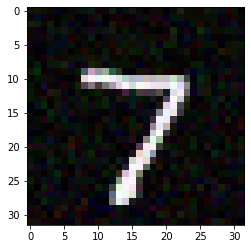

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


Adversarial image at step 96. L2 error 787.3524207577188 and class label 4.


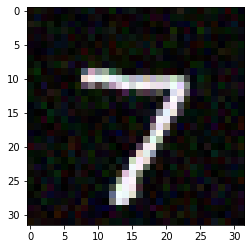

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


Adversarial image at step 97. L2 error 784.0159312873587 and class label 4.


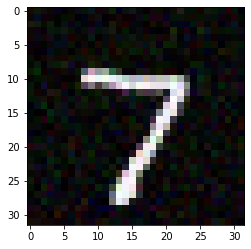

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


Adversarial image at step 98. L2 error 779.8958165380288 and class label 4.


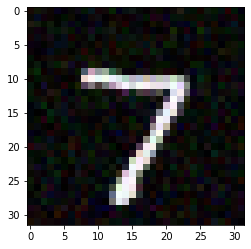

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.19s/it]


Adversarial image at step 99. L2 error 776.0872949422812 and class label 4.


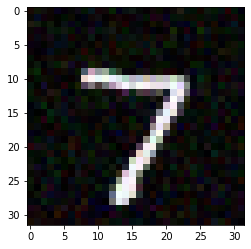

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.95s/it]


Adversarial image at step 100. L2 error 770.5996183133581 and class label 4.


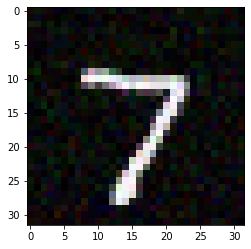

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 101. L2 error 766.2866815790188 and class label 4.


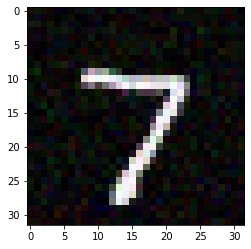

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Adversarial image at step 102. L2 error 760.8382171697415 and class label 4.


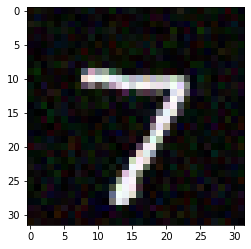

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


Adversarial image at step 103. L2 error 752.1527289214238 and class label 4.


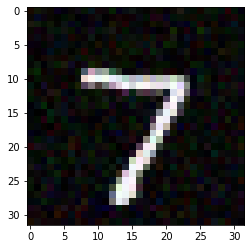

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.99s/it]


Adversarial image at step 104. L2 error 743.9707069600975 and class label 4.


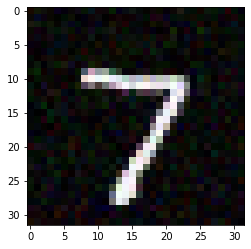

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Adversarial image at step 105. L2 error 735.5154054407095 and class label 4.


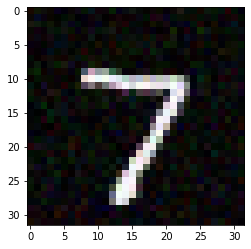

Boundary attack: 100%|██████████| 1/1 [00:12<00:00, 12.64s/it]


Adversarial image at step 106. L2 error 729.595834599006 and class label 4.


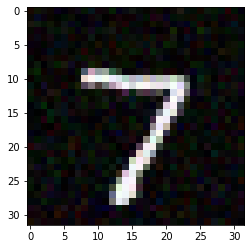

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


Adversarial image at step 107. L2 error 724.4576884055468 and class label 4.


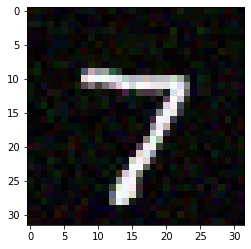

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]


Adversarial image at step 108. L2 error 719.2602300044475 and class label 4.


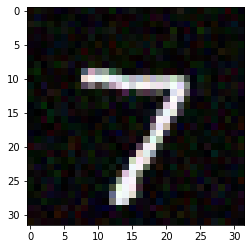

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


Adversarial image at step 109. L2 error 717.5171092783636 and class label 4.


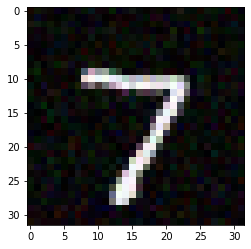

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


Adversarial image at step 110. L2 error 715.9352556508974 and class label 4.


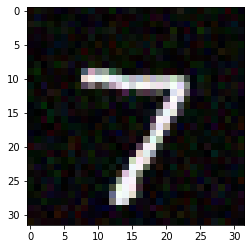

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]


Adversarial image at step 111. L2 error 714.2877998606983 and class label 4.


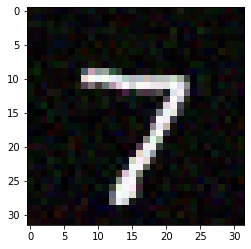

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


Adversarial image at step 112. L2 error 712.5954411793149 and class label 4.


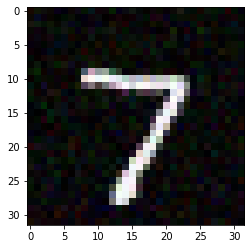

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


Adversarial image at step 113. L2 error 711.0260468610923 and class label 4.


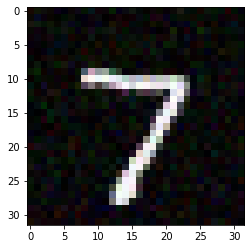

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


Adversarial image at step 114. L2 error 709.4710767021407 and class label 4.


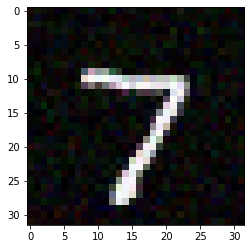

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


Adversarial image at step 115. L2 error 707.271583147789 and class label 4.


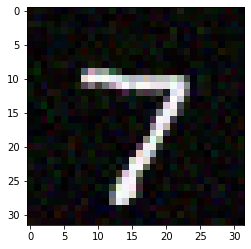

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


Adversarial image at step 116. L2 error 704.9988144453022 and class label 4.


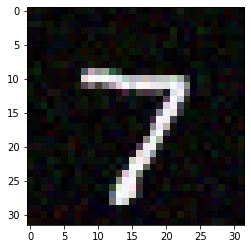

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


Adversarial image at step 117. L2 error 701.7478185281421 and class label 4.


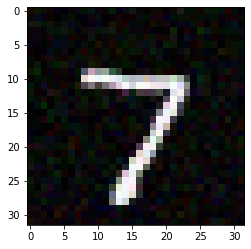

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Adversarial image at step 118. L2 error 698.3249688706165 and class label 4.


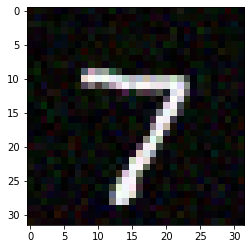

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


Adversarial image at step 119. L2 error 694.5501262001859 and class label 4.


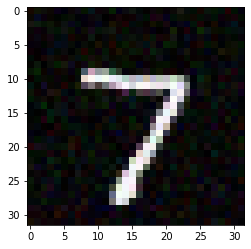

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


Adversarial image at step 120. L2 error 691.1888300895125 and class label 4.


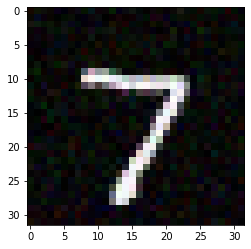

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


Adversarial image at step 121. L2 error 688.9355049873337 and class label 4.


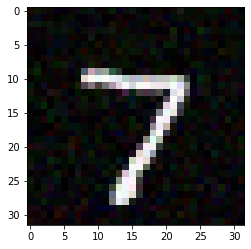

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Adversarial image at step 122. L2 error 686.636312233331 and class label 4.


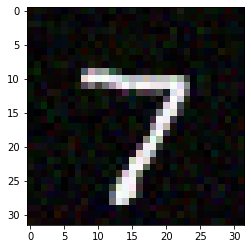

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


Adversarial image at step 123. L2 error 684.1203556104508 and class label 4.


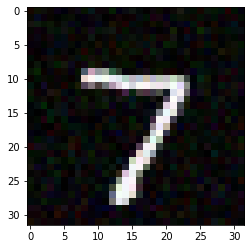

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Adversarial image at step 124. L2 error 682.1067876897957 and class label 4.


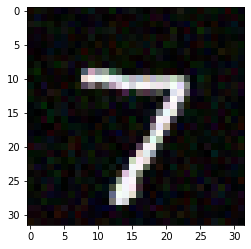

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


Adversarial image at step 125. L2 error 679.871433073131 and class label 4.


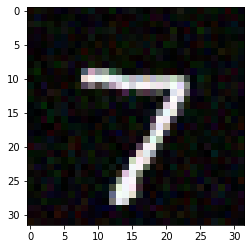

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


Adversarial image at step 126. L2 error 676.6466235857038 and class label 4.


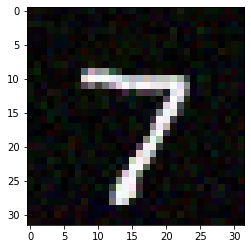

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


Adversarial image at step 127. L2 error 672.0384104212967 and class label 4.


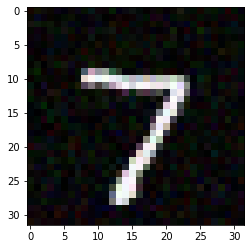

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


Adversarial image at step 128. L2 error 664.6319956084604 and class label 4.


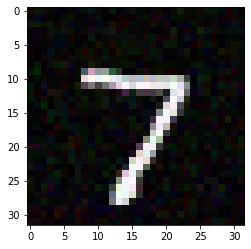

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


Adversarial image at step 129. L2 error 660.2139124746654 and class label 4.


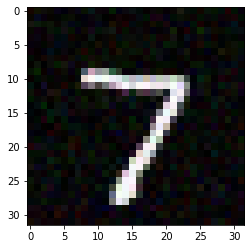

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Adversarial image at step 130. L2 error 652.9449020486771 and class label 4.


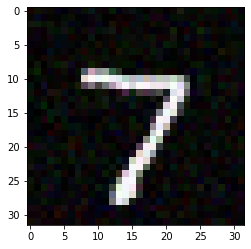

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


Adversarial image at step 131. L2 error 647.5572866134431 and class label 4.


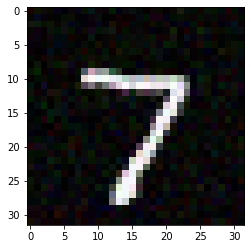

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


Adversarial image at step 132. L2 error 645.6508364560461 and class label 4.


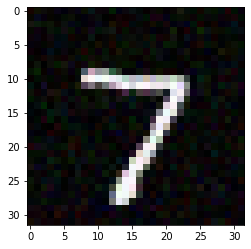

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


Adversarial image at step 133. L2 error 643.4525118563273 and class label 4.


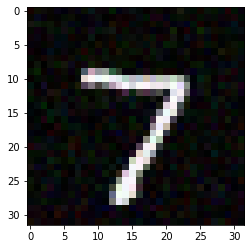

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.67s/it]


Adversarial image at step 134. L2 error 640.1320172088234 and class label 4.


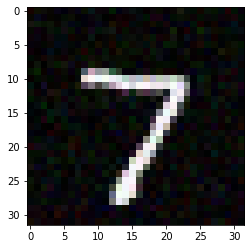

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


Adversarial image at step 135. L2 error 637.0207402841712 and class label 4.


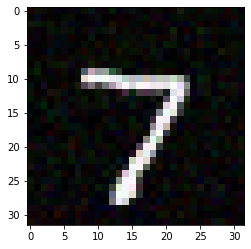

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


Adversarial image at step 136. L2 error 635.038321648955 and class label 4.


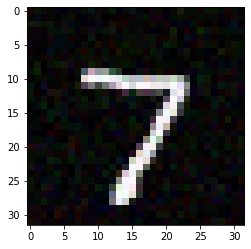

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.04s/it]


Adversarial image at step 137. L2 error 631.866069232643 and class label 4.


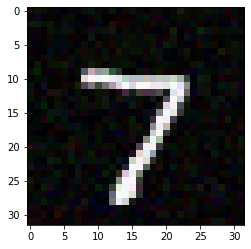

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.80s/it]


Adversarial image at step 138. L2 error 628.4005673873255 and class label 4.


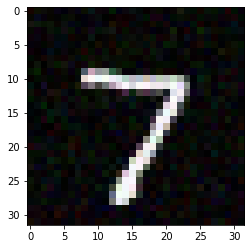

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.26s/it]


Adversarial image at step 139. L2 error 625.2783729333621 and class label 4.


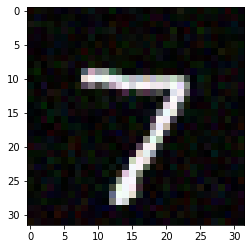

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.54s/it]


Adversarial image at step 140. L2 error 623.2766309750871 and class label 4.


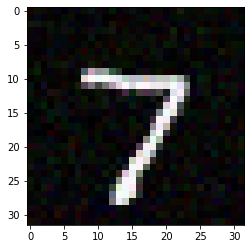

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.98s/it]


Adversarial image at step 141. L2 error 621.2862324642579 and class label 4.


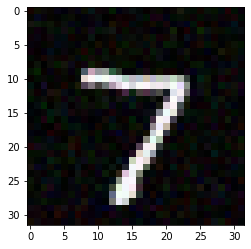

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


Adversarial image at step 142. L2 error 619.0622495979036 and class label 4.


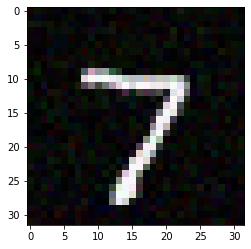

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.13s/it]


Adversarial image at step 143. L2 error 616.0474757912338 and class label 4.


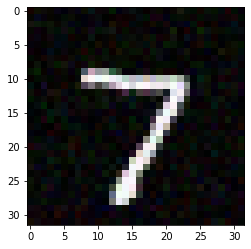

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


Adversarial image at step 144. L2 error 611.5329031150211 and class label 4.


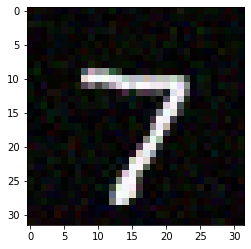

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


Adversarial image at step 145. L2 error 606.3559322388321 and class label 4.


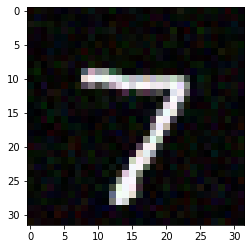

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


Adversarial image at step 146. L2 error 601.6107104275954 and class label 4.


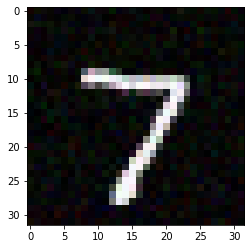

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


Adversarial image at step 147. L2 error 596.7694768609317 and class label 4.


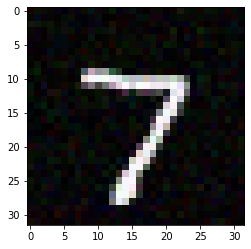

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


Adversarial image at step 148. L2 error 595.9365125383965 and class label 4.


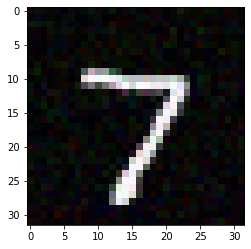

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Adversarial image at step 149. L2 error 595.2105056228094 and class label 4.


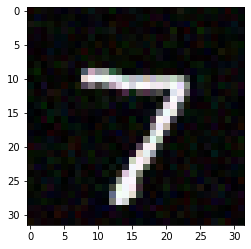

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Adversarial image at step 150. L2 error 594.3912368417406 and class label 4.


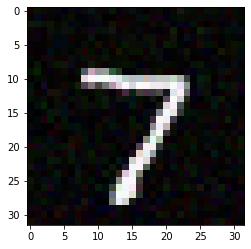

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.35s/it]


Adversarial image at step 151. L2 error 593.1755271048347 and class label 4.


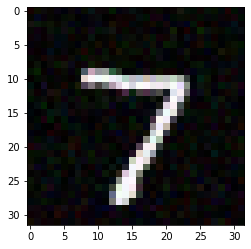

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.75s/it]


Adversarial image at step 152. L2 error 591.1536385001784 and class label 4.


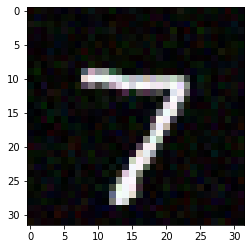

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


Adversarial image at step 153. L2 error 587.8293809107743 and class label 4.


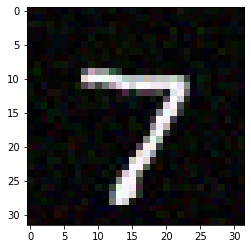

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]


Adversarial image at step 154. L2 error 585.0047231051072 and class label 4.


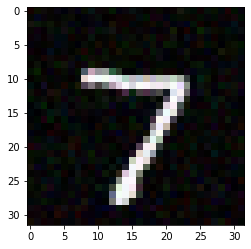

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.15s/it]


Adversarial image at step 155. L2 error 581.7509546527655 and class label 4.


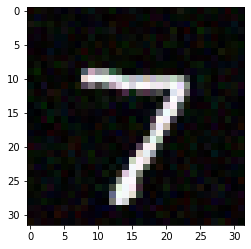

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Adversarial image at step 156. L2 error 578.8365392795134 and class label 4.


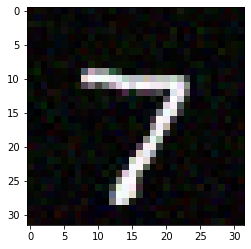

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 157. L2 error 574.4585423069524 and class label 4.


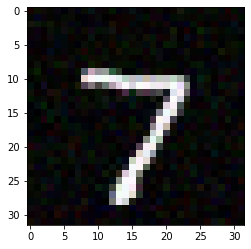

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


Adversarial image at step 158. L2 error 571.1149130902352 and class label 4.


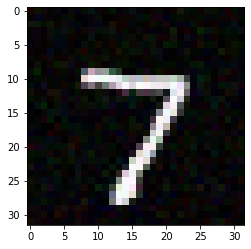

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.44s/it]


Adversarial image at step 159. L2 error 564.6460662238304 and class label 4.


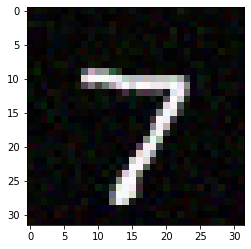

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


Adversarial image at step 160. L2 error 560.1314201043513 and class label 4.


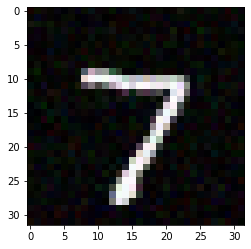

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


Adversarial image at step 161. L2 error 555.7614865902647 and class label 4.


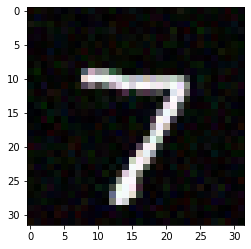

Boundary attack: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


Adversarial image at step 162. L2 error 550.372122728427 and class label 4.


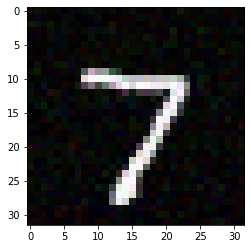

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


Adversarial image at step 163. L2 error 544.1114119928749 and class label 4.


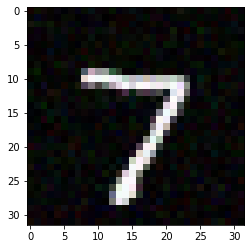

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


Adversarial image at step 164. L2 error 540.2685041609496 and class label 4.


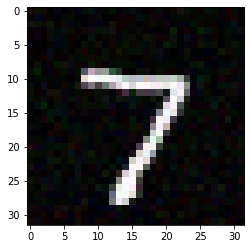

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.47s/it]


Adversarial image at step 165. L2 error 536.259503011522 and class label 4.


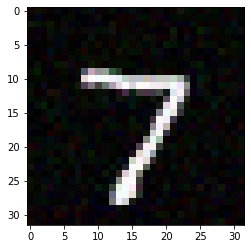

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.36s/it]


Adversarial image at step 166. L2 error 532.0224930068116 and class label 4.


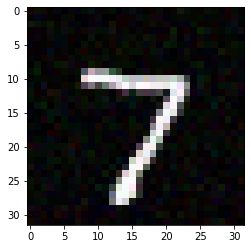

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


Adversarial image at step 167. L2 error 525.7496570745038 and class label 4.


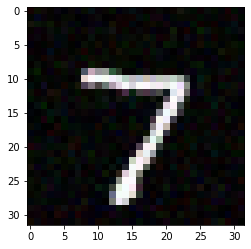

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.43s/it]


Adversarial image at step 168. L2 error 519.4522158971263 and class label 4.


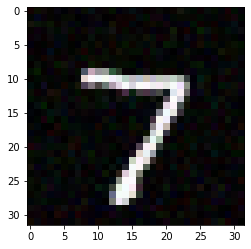

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]


Adversarial image at step 169. L2 error 512.8217651502696 and class label 4.


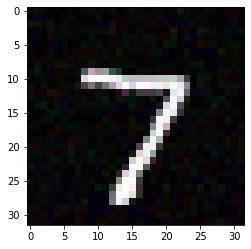

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


Adversarial image at step 170. L2 error 507.580499188202 and class label 4.


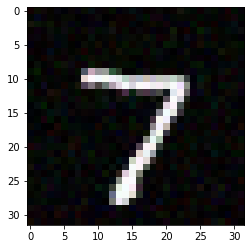

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


Adversarial image at step 171. L2 error 503.75938944967186 and class label 4.


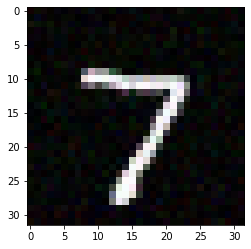

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


Adversarial image at step 172. L2 error 501.1999672384316 and class label 4.


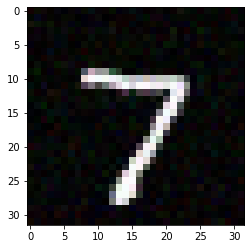

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


Adversarial image at step 173. L2 error 498.2221851907903 and class label 4.


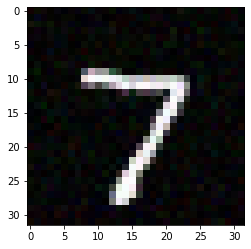

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


Adversarial image at step 174. L2 error 495.7543106666494 and class label 4.


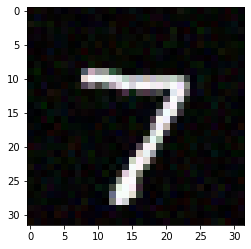

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]


Adversarial image at step 175. L2 error 496.10078690545697 and class label 4.


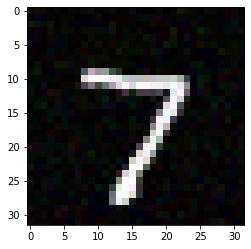

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


Adversarial image at step 176. L2 error 496.4586742575988 and class label 4.


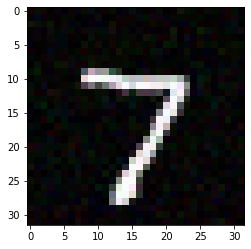

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 177. L2 error 496.4128471641384 and class label 4.


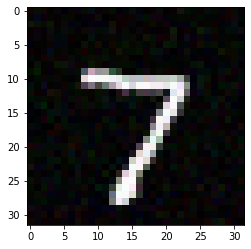

Boundary attack: 100%|██████████| 1/1 [00:08<00:00,  8.65s/it]


Adversarial image at step 178. L2 error 496.4020458926428 and class label 4.


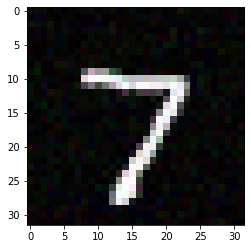

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  7.00s/it]


Adversarial image at step 179. L2 error 496.7258565597138 and class label 4.


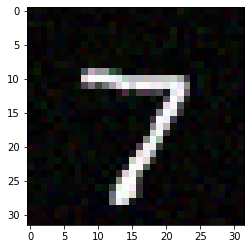

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


Adversarial image at step 180. L2 error 496.4328672892558 and class label 4.


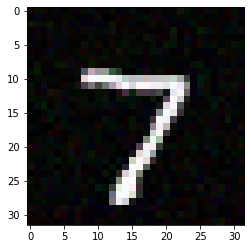

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


Adversarial image at step 181. L2 error 496.4152384560126 and class label 4.


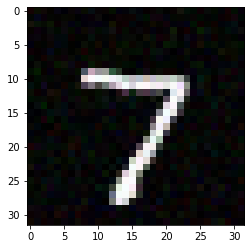

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


Adversarial image at step 182. L2 error 496.7162023352991 and class label 4.


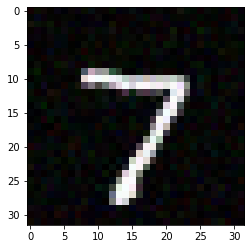

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


Adversarial image at step 183. L2 error 496.0881204108166 and class label 4.


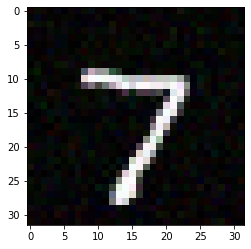

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


Adversarial image at step 184. L2 error 495.875992940578 and class label 4.


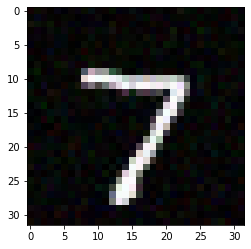

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


Adversarial image at step 185. L2 error 495.0922316944001 and class label 4.


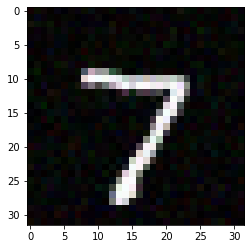

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


Adversarial image at step 186. L2 error 493.8316301550898 and class label 4.


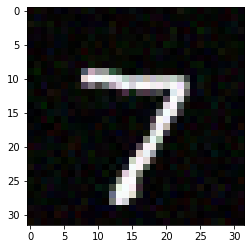

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


Adversarial image at step 187. L2 error 492.27546874101955 and class label 4.


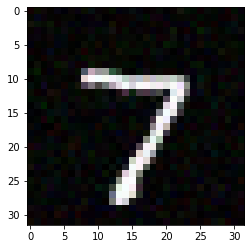

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Adversarial image at step 188. L2 error 490.9018940803107 and class label 4.


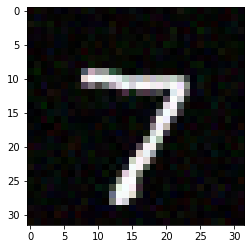

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


Adversarial image at step 189. L2 error 488.2522995087297 and class label 4.


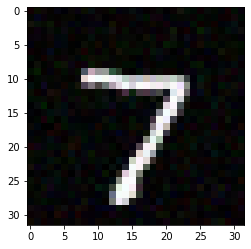

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Adversarial image at step 190. L2 error 484.00208668416076 and class label 4.


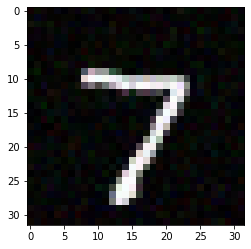

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


Adversarial image at step 191. L2 error 478.3707454246897 and class label 4.


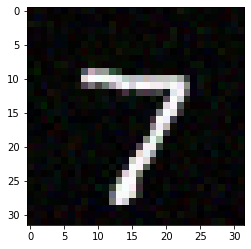

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]


Adversarial image at step 192. L2 error 469.51426644499236 and class label 4.


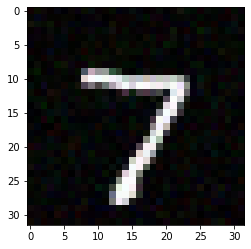

Boundary attack: 100%|██████████| 1/1 [00:09<00:00,  9.73s/it]


Adversarial image at step 193. L2 error 462.304699178545 and class label 4.


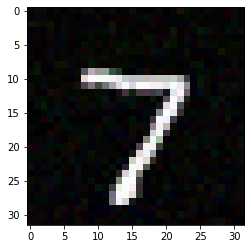

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


Adversarial image at step 194. L2 error 457.02899115782435 and class label 4.


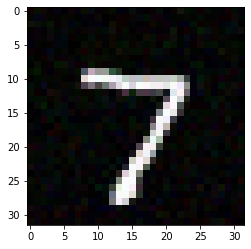

Boundary attack: 100%|██████████| 1/1 [00:05<00:00,  5.55s/it]


Adversarial image at step 195. L2 error 453.5900827054945 and class label 4.


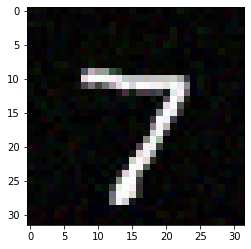

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


Adversarial image at step 196. L2 error 451.954144782052 and class label 4.


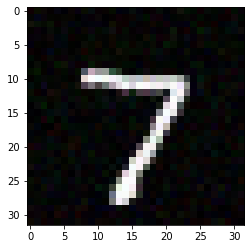

Boundary attack: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]


Adversarial image at step 197. L2 error 449.5041212740622 and class label 4.


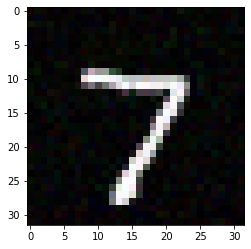

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Adversarial image at step 198. L2 error 447.48990743244184 and class label 4.


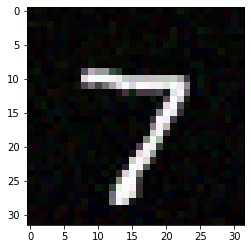

Boundary attack: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


Adversarial image at step 199. L2 error 444.9146036080377 and class label 4.


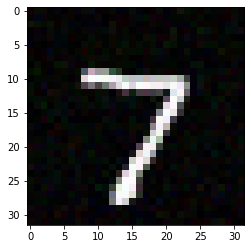

In [18]:
classifier = TensorFlowV2Classifier(model=model_effnet, input_shape=(32,32,3),clip_values=(0, 255),nb_classes=10)
degree_of_change={}
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step =1
x_adv = None
for i in range(200):
    x_adv = attack.generate(x=np.array([X_test[0]]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - X_test[0], [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    degree_of_change[i * iter_step]=DOC([x_adv[0]],[X_test[0]])
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break


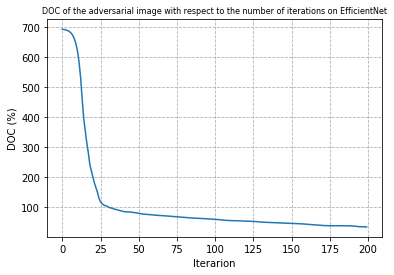

In [21]:
plt.plot(list(degree_of_change.keys()),list(degree_of_change.values()))
plt.grid(True,which="both", linestyle='--')
plt.title('DOC of the adversarial image with respect to the number of iterations on EfficientNet', fontsize=8)
plt.xlabel('Iterarion')
plt.ylabel('DOC (%)')
plt.show()